# Dutch Startup Ecosystem Analysis

**Question**: What can policymakers do to support the startup ecosystem?

**Data**: 48,000+ Venture Capital-backed companies (2005-2014 first funding), Crunchbase

---

## Notebook Structure
1. **Setup & Data Cleaning**
2. **EDA: Comprehensive Distributions**
3. **EDA: Cohort Analysis**
4. **Funnel Analysis**
5. **Key Findings Charts**

---

In [77]:
# === PART 1: SETUP & DATA CLEANING ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Color scheme
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
TECHLEAP_RED = '#D55E00'

COUNTRY_COLORS = {
    'nl': '#D55E00', 'usa': '#0072B2', 'israel': '#009E73',
    'uk': '#56B4E9', 'germany': '#E69F00', 'france': '#CC79A7',
    'gray': '#999999', 'success': '#009E73', 'failure': '#D55E00'
}

def tufte_style(ax):
    """Apply clean Tufte-style formatting to axes."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#666666')
    ax.spines['bottom'].set_color('#666666')
    ax.tick_params(colors='#666666')
    return ax

# Create figures directory
os.makedirs('figures', exist_ok=True)

# Load data
df_raw = df_raw = pd.read_csv('../investments_VC.csv', encoding='latin-1')


# Clean column names
df = df_raw.copy()
df.columns = df.columns.str.strip()
df['country_code'] = df['country_code'].str.strip()
df['market'] = df['market'].str.strip() if 'market' in df.columns else None

# Parse dates and filter to 2005-2014 cohort
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
df = df[df['first_funding_at'].notna()]
df['first_funding_year'] = df['first_funding_at'].dt.year
df_filtered = df[(df['first_funding_year'] >= 2005) & (df['first_funding_year'] <= 2014)].copy()

# Parse founded year
df_filtered['founded_year'] = pd.to_numeric(df_filtered['founded_at'].str[:4], errors='coerce')

# Clean funding columns
round_cols = ['seed', 'round_A', 'round_B', 'round_C', 'round_D']
for col in round_cols + ['funding_rounds', 'funding_total_usd']:
    if col in df_filtered.columns:
        df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce').fillna(0)

# Create derived columns
df_filtered['had_seed'] = df_filtered['seed'] > 0
df_filtered['had_series_a'] = df_filtered['round_A'] > 0
df_filtered['had_series_b'] = df_filtered['round_B'] > 0
df_filtered['had_series_c'] = df_filtered['round_C'] > 0
df_filtered['exited'] = df_filtered['status'].isin(['acquired', 'ipo'])
df_filtered['failed'] = df_filtered['status'] == 'closed'
df_filtered['operating'] = df_filtered['status'] == 'operating'

# Dutch subset
dutch = df_filtered[df_filtered['country_code'] == 'NLD'].copy()

# Country mapping
COUNTRIES = {'NLD': 'Netherlands', 'USA': 'USA', 'ISR': 'Israel', 
             'GBR': 'UK', 'DEU': 'Germany', 'FRA': 'France'}

print(f"Loaded {len(df_raw):,} companies")
print(f"Filtered dataset: {len(df_filtered):,} companies (2005-2014 first funding)")
print(f"Dutch companies: {len(dutch):,}")
print(f"\nStatus distribution:")
print(df_filtered['status'].value_counts())

Loaded 54,294 companies
Filtered dataset: 48,163 companies (2005-2014 first funding)
Dutch companies: 305

Status distribution:
status
operating    41037
acquired      3318
closed        2564
Name: count, dtype: int64


Funding stats: min=$1,100, max=$30,079,503,000, median=$1,978,398


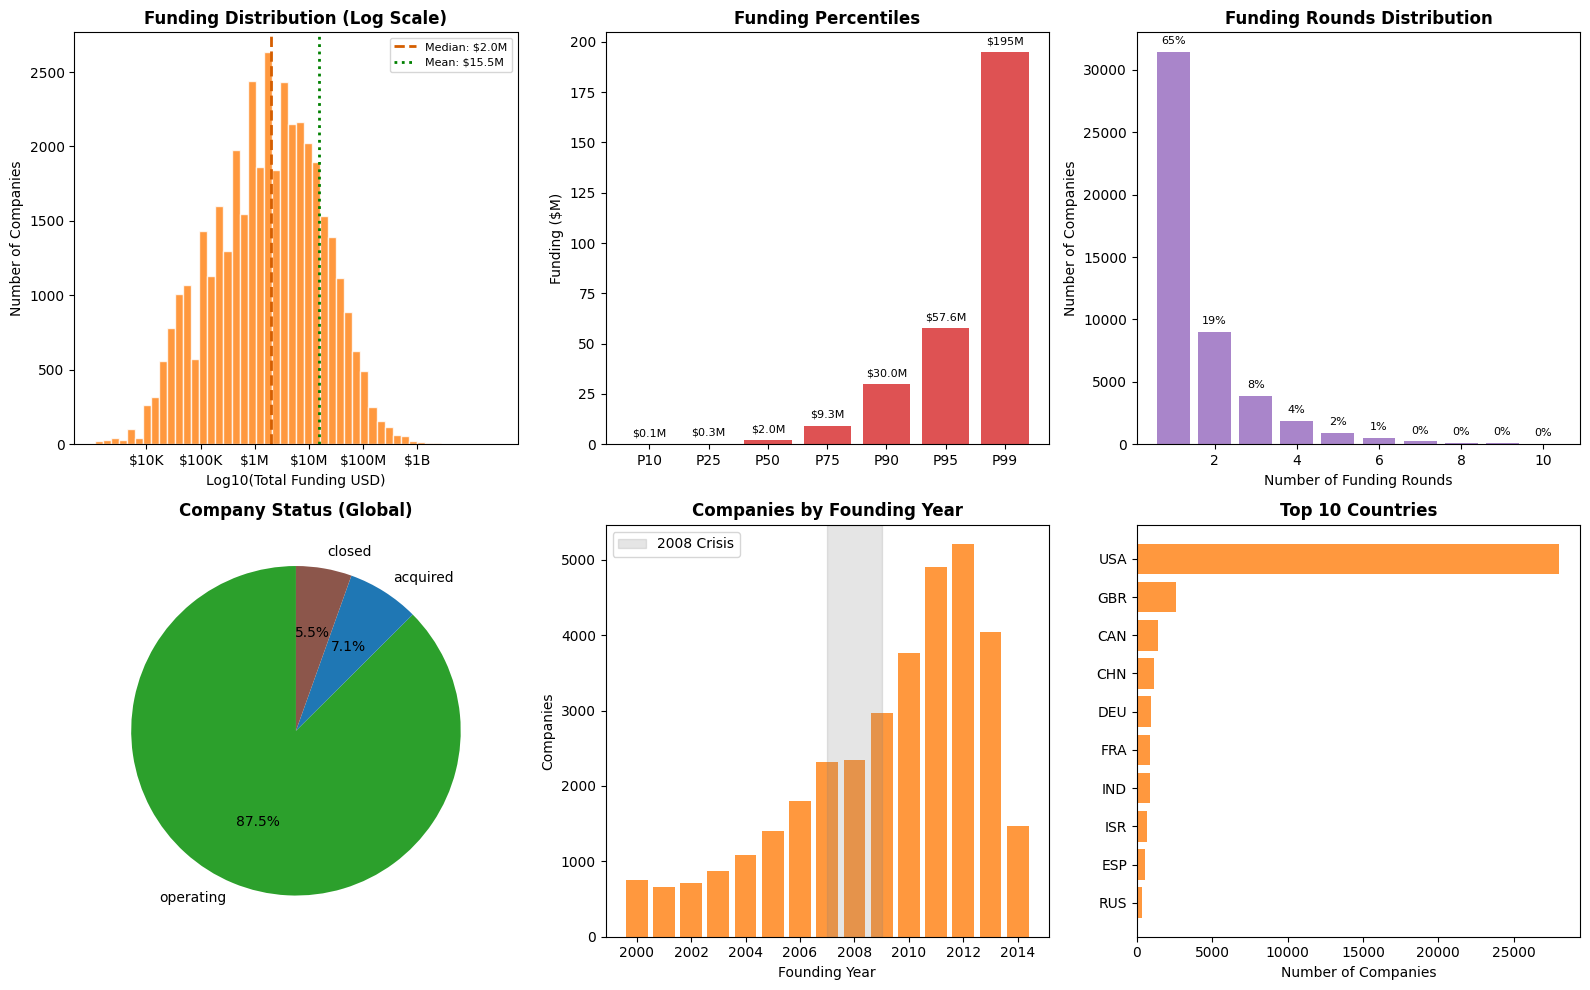

                    KEY DISTRIBUTION STATISTICS

FUNDING AMOUNTS (n=39,978 companies with funding > $1K)
   Median: $1,978,398 ($1.98M)
   Mean:   $15,474,763 ($15.47M)

FUNDING ROUNDS: 65.3% have only 1 round


In [78]:
# === PART 2: EDA - COMPREHENSIVE DISTRIBUTIONS ===

# Re-read funding data fresh from CSV (Part 1 corrupted funding_total_usd)
funding_fix = pd.read_csv('../investments_VC.csv', encoding='latin-1')
funding_fix.columns = funding_fix.columns.str.strip()
funding_fix['funding_total_usd'] = (funding_fix['funding_total_usd']
                                    .astype(str)
                                    .str.replace(',', '', regex=False)
                                    .str.replace(' ', '', regex=False))
funding_fix['funding_total_usd'] = pd.to_numeric(funding_fix['funding_total_usd'], errors='coerce').fillna(0)

# Merge clean funding back into df_filtered
df_filtered = df_filtered.drop(columns=['funding_total_usd'], errors='ignore')
df_filtered = df_filtered.merge(funding_fix[['permalink', 'funding_total_usd']], on='permalink', how='left')

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Get funding data (filter out zeros and very small values)
funding_nonzero = df_filtered[df_filtered['funding_total_usd'] > 1000]['funding_total_usd']

print(f"Funding stats: min=${funding_nonzero.min():,.0f}, max=${funding_nonzero.max():,.0f}, median=${funding_nonzero.median():,.0f}")

# 1a. Raw funding distribution (log scale)
ax1 = axes[0, 0]
log_funding = np.log10(funding_nonzero)
ax1.hist(log_funding, bins=50, color=COLORS[1], alpha=0.8, edgecolor='white')
median_log = np.log10(funding_nonzero.median())
mean_log = np.log10(funding_nonzero.mean())
ax1.axvline(median_log, color=TECHLEAP_RED, linestyle='--', linewidth=2, label=f'Median: ${funding_nonzero.median()/1e6:.1f}M')
ax1.axvline(mean_log, color='green', linestyle=':', linewidth=2, label=f'Mean: ${funding_nonzero.mean()/1e6:.1f}M')
ax1.set_xlabel('Log10(Total Funding USD)')
ax1.set_ylabel('Number of Companies')
ax1.set_title('Funding Distribution (Log Scale)', fontweight='bold')
ax1.legend(fontsize=8)
ax1.set_xticks([4, 5, 6, 7, 8, 9])
ax1.set_xticklabels(['$10K', '$100K', '$1M', '$10M', '$100M', '$1B'])

# 1b. Funding percentiles
ax2 = axes[0, 1]
percentiles = [10, 25, 50, 75, 90, 95, 99]
pct_values = [funding_nonzero.quantile(p/100) / 1e6 for p in percentiles]
bars = ax2.bar([f'P{p}' for p in percentiles], pct_values, color=COLORS[3], alpha=0.8)
ax2.set_ylabel('Funding ($M)')
ax2.set_title('Funding Percentiles', fontweight='bold')
for i, v in enumerate(pct_values):
    label = f'${v:.1f}M' if v < 100 else f'${v:.0f}M'
    ax2.text(i, v + max(pct_values)*0.02, label, ha='center', fontsize=8)

# 1c. Funding rounds distribution
ax3 = axes[0, 2]
rounds_dist = df_filtered['funding_rounds'].value_counts().sort_index().head(10)
ax3.bar(rounds_dist.index, rounds_dist.values, color=COLORS[4], alpha=0.8)
ax3.set_xlabel('Number of Funding Rounds')
ax3.set_ylabel('Number of Companies')
ax3.set_title('Funding Rounds Distribution', fontweight='bold')
for idx, v in rounds_dist.items():
    pct = v / len(df_filtered) * 100
    ax3.text(idx, v + max(rounds_dist.values)*0.02, f'{pct:.0f}%', ha='center', fontsize=8)

# 1d. Status distribution (global)
ax4 = axes[1, 0]
status_counts = df_filtered['status'].value_counts()
colors_status = [COLORS[2] if s == 'operating' else COLORS[0] if s == 'acquired' else COLORS[5] for s in status_counts.index]
wedges, texts, autotexts = ax4.pie(status_counts.values, labels=status_counts.index, colors=colors_status, autopct='%1.1f%%', startangle=90)
ax4.set_title('Company Status (Global)', fontweight='bold')

# 1e. Companies by founding year
ax5 = axes[1, 1]
year_counts = df_filtered['founded_year'].value_counts().sort_index()
year_counts = year_counts[(year_counts.index >= 2000) & (year_counts.index <= 2014)]
ax5.bar(year_counts.index, year_counts.values, color=COLORS[1], alpha=0.8)
ax5.axvspan(2007, 2009, alpha=0.2, color='gray', label='2008 Crisis')
ax5.set_xlabel('Founding Year')
ax5.set_ylabel('Companies')
ax5.set_title('Companies by Founding Year', fontweight='bold')
ax5.legend()

# 1f. Top countries
ax6 = axes[1, 2]
country_counts = df_filtered['country_code'].value_counts().head(10)
colors_country = [TECHLEAP_RED if c == 'NLD' else COLORS[1] for c in country_counts.index]
ax6.barh(range(len(country_counts)), country_counts.values, color=colors_country, alpha=0.8)
ax6.set_yticks(range(len(country_counts)))
ax6.set_yticklabels(country_counts.index)
ax6.set_xlabel('Number of Companies')
ax6.set_title('Top 10 Countries', fontweight='bold')
ax6.invert_yaxis()

plt.tight_layout()
plt.savefig('figures/01_comprehensive_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("="*70)
print("                    KEY DISTRIBUTION STATISTICS")
print("="*70)
print(f"\nFUNDING AMOUNTS (n={len(funding_nonzero):,} companies with funding > $1K)")
print(f"   Median: ${funding_nonzero.median():,.0f} (${funding_nonzero.median()/1e6:.2f}M)")
print(f"   Mean:   ${funding_nonzero.mean():,.0f} (${funding_nonzero.mean()/1e6:.2f}M)")
single_round = (df_filtered['funding_rounds'] == 1).sum()
print(f"\nFUNDING ROUNDS: {single_round/len(df_filtered)*100:.1f}% have only 1 round")

Cohort Analysis by Founding Year:
              Company_Count  Avg_Funding  Median_Funding  Total_Funding  \
founded_year                                                              
2005.0                 1408  26668393.34       5925000.0   3.754910e+10   
2006.0                 1802  20216609.46       4000000.0   3.643033e+10   
2007.0                 2324  21341113.34       2500000.0   4.959675e+10   
2008.0                 2342  12901328.69       1687095.0   3.021491e+10   
2009.0                 2975  10539964.99       1025000.0   3.135640e+10   
2010.0                 3768   7484597.78        769517.5   2.820196e+10   
2011.0                 4904   5099594.60        565000.0   2.500841e+10   
2012.0                 5205   3780387.84        300000.0   1.967692e+10   
2013.0                 4042   2240972.57        150000.0   9.058011e+09   
2014.0                 1467   1291041.25         48312.0   1.893958e+09   

              Avg_Rounds  Operating_Rate  
founded_year          

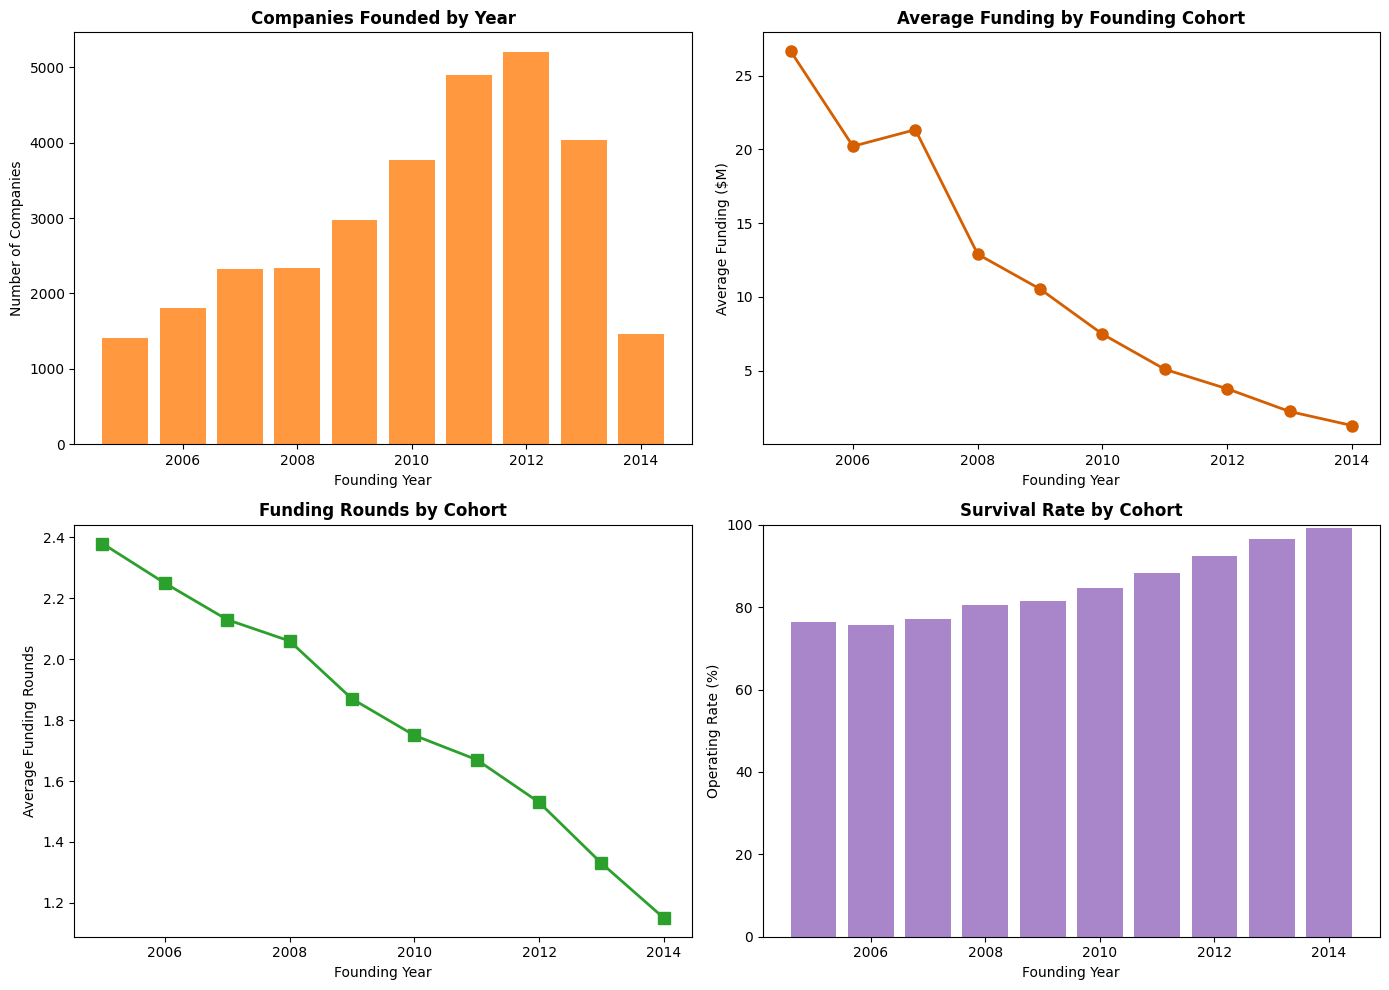

In [79]:
# === PART 3: EDA - COHORT ANALYSIS ===
# Source: legacy/task-1-analysis/analysis.ipynb

# Create cohort analysis DataFrame
cohort_analysis = df_filtered.groupby('founded_year').agg({
    'permalink': 'count',
    'funding_total_usd': ['mean', 'median', 'sum'],
    'funding_rounds': 'mean',
    'status': lambda x: (x == 'operating').mean() * 100
}).round(2)

cohort_analysis.columns = ['Company_Count', 'Avg_Funding', 'Median_Funding', 'Total_Funding', 'Avg_Rounds', 'Operating_Rate']
cohort_analysis = cohort_analysis[(cohort_analysis.index >= 2005) & (cohort_analysis.index <= 2014)]

print("Cohort Analysis by Founding Year:")
print(cohort_analysis)

# Visualization: Cohort trends
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Company count by year
ax1 = axes[0, 0]
ax1.bar(cohort_analysis.index, cohort_analysis['Company_Count'], color=COLORS[1], alpha=0.8)
ax1.set_xlabel('Founding Year')
ax1.set_ylabel('Number of Companies')
ax1.set_title('Companies Founded by Year', fontweight='bold')

# Average funding by year
ax2 = axes[0, 1]
ax2.plot(cohort_analysis.index, cohort_analysis['Avg_Funding']/1e6, 'o-', color=TECHLEAP_RED, linewidth=2, markersize=8)
ax2.set_xlabel('Founding Year')
ax2.set_ylabel('Average Funding ($M)')
ax2.set_title('Average Funding by Founding Cohort', fontweight='bold')

# Average rounds by year
ax3 = axes[1, 0]
ax3.plot(cohort_analysis.index, cohort_analysis['Avg_Rounds'], 's-', color=COLORS[2], linewidth=2, markersize=8)
ax3.set_xlabel('Founding Year')
ax3.set_ylabel('Average Funding Rounds')
ax3.set_title('Funding Rounds by Cohort', fontweight='bold')

# Operating rate by year
ax4 = axes[1, 1]
ax4.bar(cohort_analysis.index, cohort_analysis['Operating_Rate'], color=COLORS[4], alpha=0.8)
ax4.set_xlabel('Founding Year')
ax4.set_ylabel('Operating Rate (%)')
ax4.set_title('Survival Rate by Cohort', fontweight='bold')
ax4.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('figures/cohort_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

FUNDING FUNNEL BY COUNTRY (% reaching each stage)
             Funded  Seed  Series A  Series B  Series C  Exited      n
country                                                               
Netherlands     100  31.8      11.5       7.2       2.0     4.3    305
USA             100  24.9      19.9      12.6       7.0     8.9  28009
Israel          100  27.0      25.2      16.0       7.3     8.5    674
UK              100  30.3      13.4       7.6       3.4     5.0   2580
Germany         100  25.1      14.0       9.1       3.8     7.0    947
France          100  25.8      25.4      13.6       5.3     4.8    852


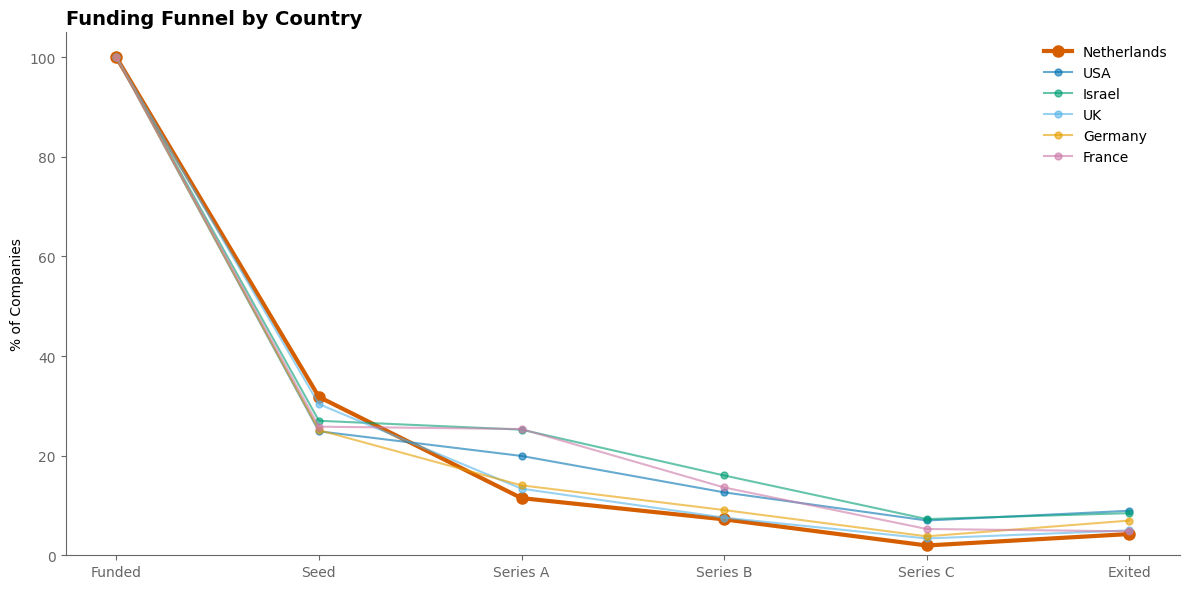


STAGE-TO-STAGE CONVERSION RATES (%)
             Seed→A   A→B  B→Exit
country                          
Netherlands     6.2  22.9    18.2
USA            15.8  37.7    19.5
Israel         21.4  32.9    15.7
UK              8.0  27.0    13.3
Germany        11.8  20.3     8.1
France          9.5  21.3     6.0

KEY INSIGHT: Dutch Seed → Series A conversion is 6.2% vs USA 15.8% and Israel 21.4%


In [80]:
# === PART 4: FUNNEL ANALYSIS ===

# Ensure columns exist (in case Part 1 wasn't run)
df_filtered['had_seed'] = df_filtered['seed'] > 0
df_filtered['had_series_a'] = df_filtered['round_A'] > 0
df_filtered['had_series_b'] = df_filtered['round_B'] > 0
df_filtered['had_series_c'] = df_filtered['round_C'] > 0
df_filtered['exited'] = df_filtered['status'].isin(['acquired', 'ipo'])

# Calculate funnel by country
def calculate_funnel(country_code):
    subset = df_filtered[df_filtered['country_code'] == country_code]
    n = len(subset)
    if n == 0:
        return None
    
    return {
        'country': COUNTRIES.get(country_code, country_code),
        'Funded': 100,
        'Seed': subset['had_seed'].sum() / n * 100,
        'Series A': subset['had_series_a'].sum() / n * 100,
        'Series B': subset['had_series_b'].sum() / n * 100,
        'Series C': subset['had_series_c'].sum() / n * 100,
        'Exited': subset['exited'].sum() / n * 100,
        'n': n
    }

funnel_data = [calculate_funnel(c) for c in COUNTRIES.keys()]
funnel_df = pd.DataFrame(funnel_data).set_index('country')

print("FUNDING FUNNEL BY COUNTRY (% reaching each stage)")
print(funnel_df.round(1))

# Visualization: Survival funnel
fig, ax = plt.subplots(figsize=(12, 6))
tufte_style(ax)

stages = ['Funded', 'Seed', 'Series A', 'Series B', 'Series C', 'Exited']
x = np.arange(len(stages))

country_colors = {'Netherlands': COUNTRY_COLORS['nl'], 'USA': COUNTRY_COLORS['usa'], 'Israel': COUNTRY_COLORS['israel'],
                  'UK': COUNTRY_COLORS['uk'], 'Germany': COUNTRY_COLORS['germany'], 'France': COUNTRY_COLORS['france']}

for country in funnel_df.index:
    values = [funnel_df.loc[country, s] for s in stages]
    linewidth = 3 if country == 'Netherlands' else 1.5
    alpha = 1.0 if country == 'Netherlands' else 0.6
    ax.plot(x, values, marker='o', label=country, color=country_colors[country],
            linewidth=linewidth, alpha=alpha, markersize=8 if country == 'Netherlands' else 5)

ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.set_ylabel('% of Companies')
ax.set_title('Funding Funnel by Country', fontsize=14, fontweight='bold', loc='left')
ax.legend(loc='upper right', frameon=False)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig('figures/survival_funnel.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate stage-to-stage conversion rates
def conversion_rates(country_code):
    subset = df_filtered[df_filtered['country_code'] == country_code]
    
    with_seed = subset[subset['had_seed']]
    with_a = subset[subset['had_series_a']]
    with_b = subset[subset['had_series_b']]
    
    seed_to_a = with_seed['had_series_a'].sum() / len(with_seed) * 100 if len(with_seed) > 0 else 0
    a_to_b = with_a['had_series_b'].sum() / len(with_a) * 100 if len(with_a) > 0 else 0
    b_to_exit = with_b['exited'].sum() / len(with_b) * 100 if len(with_b) > 0 else 0
    
    return {
        'country': COUNTRIES.get(country_code, country_code),
        'Seed→A': seed_to_a,
        'A→B': a_to_b,
        'B→Exit': b_to_exit
    }

conv_data = [conversion_rates(c) for c in COUNTRIES.keys()]
conv_df = pd.DataFrame(conv_data).set_index('country')

print("\nSTAGE-TO-STAGE CONVERSION RATES (%)")
print(conv_df.round(1))
print("\nKEY INSIGHT: Dutch Seed → Series A conversion is 6.2% vs USA 15.8% and Israel 21.4%")

CHART #1: Funding Funnel


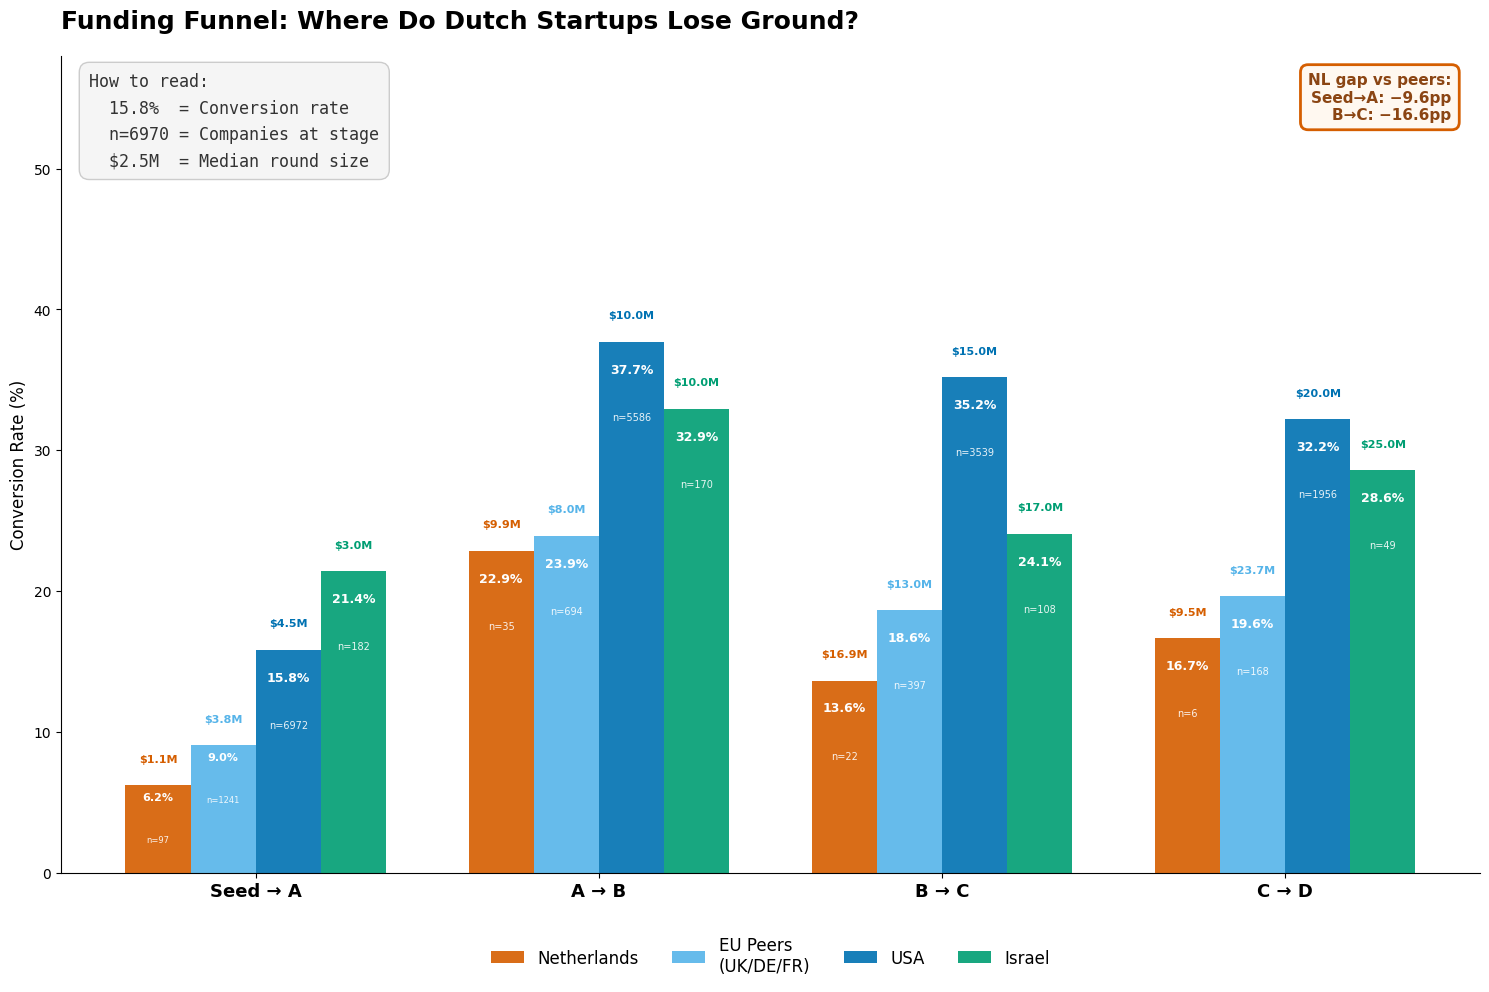

✓ Saved to figures/finding1_funding_funnel.png


In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === CHART #1: Full Funding Funnel ===
print('CHART #1: Funding Funnel')

def calc_conversion(country_codes, from_col, to_col):
    """Calculate conversion rate and median funding for the target round."""
    if 'df_filtered' not in globals():
        return 20.0, 100, 1.0
    if isinstance(country_codes, str): country_codes = [country_codes]
    subset = df_filtered[df_filtered['country_code'].isin(country_codes)]
    with_from = subset[subset[from_col] > 0]
    if len(with_from) == 0: return 0, 0, 0
    converted = (with_from[to_col] > 0).sum()
    median_funding = with_from[with_from[to_col] > 0][to_col].median() / 1e6
    if pd.isna(median_funding): median_funding = 0
    return converted / len(with_from) * 100, len(with_from), median_funding

def tufte_style(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(top=False, right=False)

regions = ['Netherlands', 'EU Peers\n(UK/DE/FR)', 'USA', 'Israel']
region_codes = [['NLD'], ['GBR', 'DEU', 'FRA'], ['USA'], ['ISR']]
region_colors = ['#D55E00', '#56B4E9', '#0072B2', '#009E73']

transitions = [
    ('Seed → A', 'seed', 'round_A'),
    ('A → B', 'round_A', 'round_B'),
    ('B → C', 'round_B', 'round_C'),
    ('C → D', 'round_C', 'round_D'),
]

fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_facecolor('none')
ax.set_facecolor('none')
tufte_style(ax)

x = np.arange(len(transitions))
width = 0.19

for i, (region, codes, color) in enumerate(zip(regions, region_codes, region_colors)):
    rates_n_funding = [calc_conversion(codes, t[1], t[2]) for t in transitions]
    rates = [r[0] for r in rates_n_funding]
    ns = [r[1] for r in rates_n_funding]
    fundings = [r[2] for r in rates_n_funding]
    
    bars = ax.bar(x + (i - 1.5) * width, rates, width, label=region, color=color, alpha=0.9)
    
    for j, (bar, rate, n, funding) in enumerate(zip(bars, rates, ns, fundings)):
        if rate > 0:
            bar_x = bar.get_x() + bar.get_width()/2
            bar_h = bar.get_height()
            
            # Format funding
            if funding >= 1:
                funding_str = f'${funding:.1f}M'
            elif funding > 0:
                funding_str = f'${funding*1000:.0f}K'
            else:
                funding_str = ''
            
            # === FUNDING ALWAYS ON TOP ===
            if funding_str:
                ax.text(bar_x, bar_h + 1.5, funding_str, 
                        ha='center', va='bottom', fontsize=8, fontweight='bold', color=color)
            
            # === RATE & N ON THE BAR ===
            if bar_h > 12:
                # Inside the bar (white text)
                ax.text(bar_x, bar_h - 1.5, f'{rate:.1f}%', 
                        ha='center', va='top', fontsize=9, fontweight='bold', color='white')
                ax.text(bar_x, bar_h - 5, f'n={n}', 
                        ha='center', va='top', fontsize=7, color='white', alpha=0.9)
            else:
                # On top of bar but below funding (colored text)
                ax.text(bar_x, bar_h - 0.5, f'{rate:.1f}%', 
                        ha='center', va='top', fontsize=8, fontweight='bold', color='white')
                ax.text(bar_x, bar_h - 3.5, f'n={n}', 
                        ha='center', va='top', fontsize=6, color='white', alpha=0.9)

ax.set_xticks(x)
ax.set_xticklabels([t[0] for t in transitions], fontsize=13, fontweight='bold')
ax.set_ylabel('Conversion Rate (%)', fontsize=12)
ax.set_ylim(0, 58)

ax.set_title('Funding Funnel: Where Do Dutch Startups Lose Ground?', 
             fontweight='bold', loc='left', fontsize=18, pad=20)

# Legend box explaining the annotations
legend_box = dict(boxstyle='round,pad=0.6', facecolor='#F5F5F5', edgecolor='#CCCCCC', linewidth=1)
ax.text(0.02, 0.98, 
        'How to read:\n'
        '  15.8%  = Conversion rate\n'
        '  n=6970 = Companies at stage\n'
        '  $2.5M  = Median round size',
        transform=ax.transAxes, fontsize=12, color='#333333',
        verticalalignment='top', ha='left', bbox=legend_box, 
        family='monospace', linespacing=1.6)

# Key insight box
insight_box = dict(boxstyle='round,pad=0.5', facecolor='#FFF8F0', edgecolor='#D55E00', linewidth=2)
ax.text(0.98, 0.98, 
        'NL gap vs peers:\n'
        'Seed→A: −9.6pp\n'
        'B→C: −16.6pp',
        transform=ax.transAxes, fontsize=11, fontweight='bold', color='#8B4513',
        verticalalignment='top', ha='right', bbox=insight_box)

# Country legend at bottom
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), ncol=4, 
          frameon=False, fontsize=12)

plt.tight_layout()
plt.savefig('figures/finding1_funding_funnel.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()

print('✓ Saved to figures/finding1_funding_funnel.png')

Playing It Small


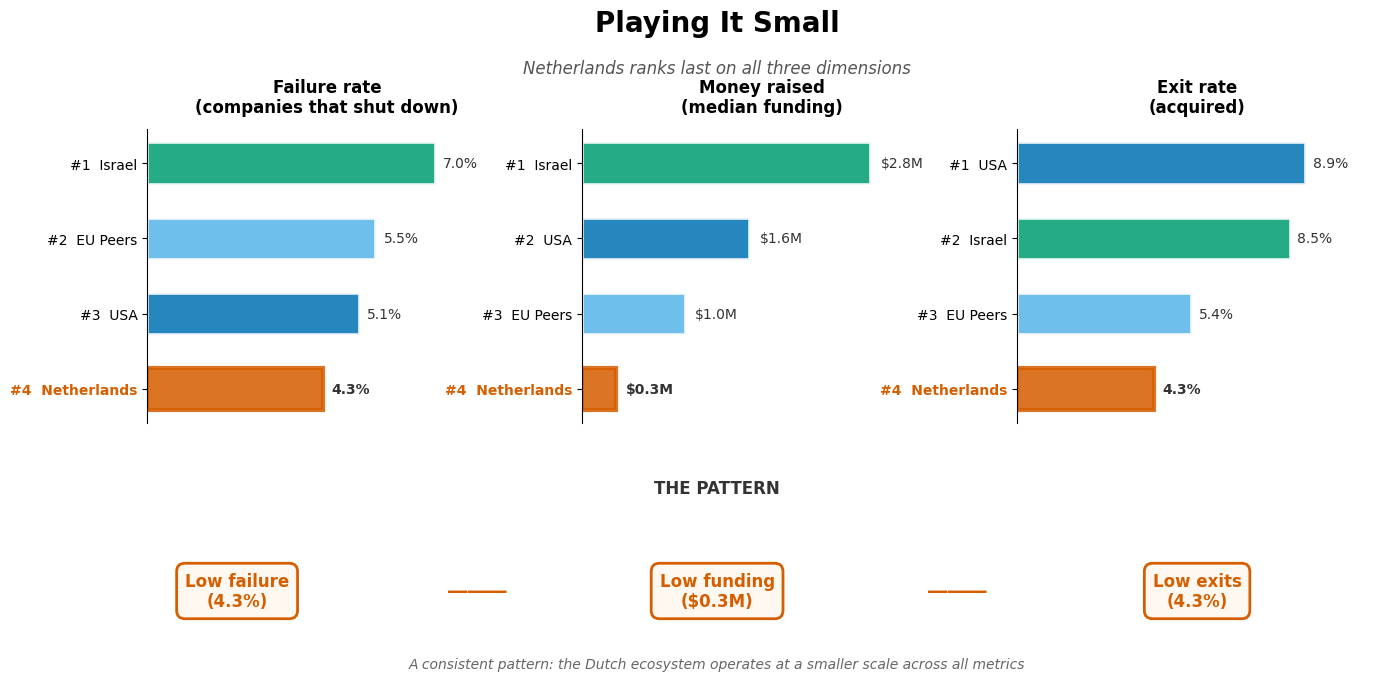

✓ Saved to figures/finding2_playing_small.png


In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === CHART #2: Playing It Small — Final Version ===
print('Playing It Small')

def get_metrics(codes):
    subset = df_filtered[df_filtered['country_code'].isin(codes)]
    n = len(subset)
    if n == 0: return {'failure': 0, 'exit': 0, 'funding': 0, 'n': 0}
    
    failure = (subset['status'] == 'closed').sum() / n * 100
    exit_rate = subset['exited'].sum() / n * 100
    median_funding = subset['funding_total_usd'].median() / 1e6
    if pd.isna(median_funding): median_funding = 0
    
    return {'failure': failure, 'exit': exit_rate, 'funding': median_funding, 'n': n}

regions = ['USA', 'Israel', 'EU Peers', 'Netherlands']
codes = {'USA': ['USA'], 'Israel': ['ISR'], 'EU Peers': ['GBR', 'DEU', 'FRA'], 'Netherlands': ['NLD']}
colors = {'USA': '#0072B2', 'Israel': '#009E73', 'EU Peers': '#56B4E9', 'Netherlands': '#D55E00'}

data = {r: get_metrics(codes[r]) for r in regions}

# === PLOTTING (more compact) ===
fig = plt.figure(figsize=(15, 7))  # Reduced height from 10 to 7
fig.patch.set_facecolor('none')

fig.text(0.5, 0.94, 'Playing It Small', fontsize=20, fontweight='bold', ha='center')
fig.text(0.5, 0.88, 'Netherlands ranks last on all three dimensions', 
         fontsize=12, ha='center', color='#555555', style='italic')

metrics_config = [
    ('failure', 'Failure rate', '(companies that shut down)', '%', 10),
    ('funding', 'Money raised', '(median funding)', '$M', 5),
    ('exit', 'Exit rate', '(acquired)', '%', 12),

]

for col_idx, (metric, title, subtitle, unit, max_val) in enumerate(metrics_config):
    ax = fig.add_axes([0.12 + col_idx * 0.29, 0.38, 0.24, 0.42])  # Adjusted position
    ax.set_facecolor('none')
    
    sorted_regions = sorted(regions, key=lambda r: data[r][metric], reverse=True)
    
    y_positions = np.arange(len(sorted_regions))
    values = [data[r][metric] for r in sorted_regions]
    bar_colors = [colors[r] for r in sorted_regions]
    
    bars = ax.barh(y_positions, values, color=bar_colors, height=0.55, 
                   edgecolor='white', linewidth=2, alpha=0.85)
    
    for rank, (region, val) in enumerate(zip(sorted_regions, values)):
        if unit == '$M':
            val_str = f'${val:.1f}M'
        else:
            val_str = f'{val:.1f}%'
        
        txt_weight = 'bold' if region == 'Netherlands' else 'normal'
        ax.text(val + max_val * 0.02, rank, val_str, fontsize=10, fontweight=txt_weight,
                va='center', ha='left', color='#333333')
        
        if region == 'Netherlands':
            bars[rank].set_edgecolor('#D55E00')
            bars[rank].set_linewidth(3)
    
    rank_labels = [f'#{rank+1}  {region}' for rank, region in enumerate(sorted_regions)]
    ax.set_yticks(y_positions)
    ax.set_yticklabels(rank_labels, fontsize=10)
    
    for tick, region in zip(ax.get_yticklabels(), sorted_regions):
        if region == 'Netherlands':
            tick.set_fontweight('bold')
            tick.set_color('#D55E00')
    
    ax.invert_yaxis()
    current_max = max(values) if values else 1
    ax.set_xlim(0, current_max * 1.25)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False)
    
    ax.set_title(f'{title}\n{subtitle}', fontsize=12, fontweight='bold', pad=12)

# Bottom section - THE PATTERN (moved up)
fig.text(0.5, 0.28, 'THE PATTERN', fontsize=12, fontweight='bold', ha='center', color='#333333')

nl_fail = data['Netherlands']['failure']
nl_fund = data['Netherlands']['funding']
nl_exit = data['Netherlands']['exit']

box_props = dict(boxstyle='round,pad=0.5', facecolor='#fff8f0', edgecolor='#D55E00', linewidth=2)

fig.text(0.18, 0.14, f'Low failure\n({nl_fail:.1f}%)', fontsize=12, ha='center', va='center', 
         bbox=box_props, color='#D55E00', fontweight='bold')
fig.text(0.34, 0.14, '―――', fontsize=14, ha='center', va='center', color='#D55E00', fontweight='bold')
fig.text(0.50, 0.14, f'Low funding\n(${nl_fund:.1f}M)', fontsize=12, ha='center', va='center',
         bbox=box_props, color='#D55E00', fontweight='bold')
fig.text(0.66, 0.14, '―――', fontsize=14, ha='center', va='center', color='#D55E00', fontweight='bold')
fig.text(0.82, 0.14, f'Low exits\n({nl_exit:.1f}%)', fontsize=12, ha='center', va='center',
         bbox=box_props, color='#D55E00', fontweight='bold')

fig.text(0.5, 0.03, 'A consistent pattern: the Dutch ecosystem operates at a smaller scale across all metrics', 
         fontsize=10, ha='center', color='#666666', style='italic')

plt.savefig('figures/finding2_playing_small.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()

print('✓ Saved to figures/finding2_playing_small.png')

CHART #3: The Opportunity Cost
NL Seed companies: 97
Actual → Series A: 6 (at NL's 6.2% rate)
If EU rate (9.2%): 8 (+2)


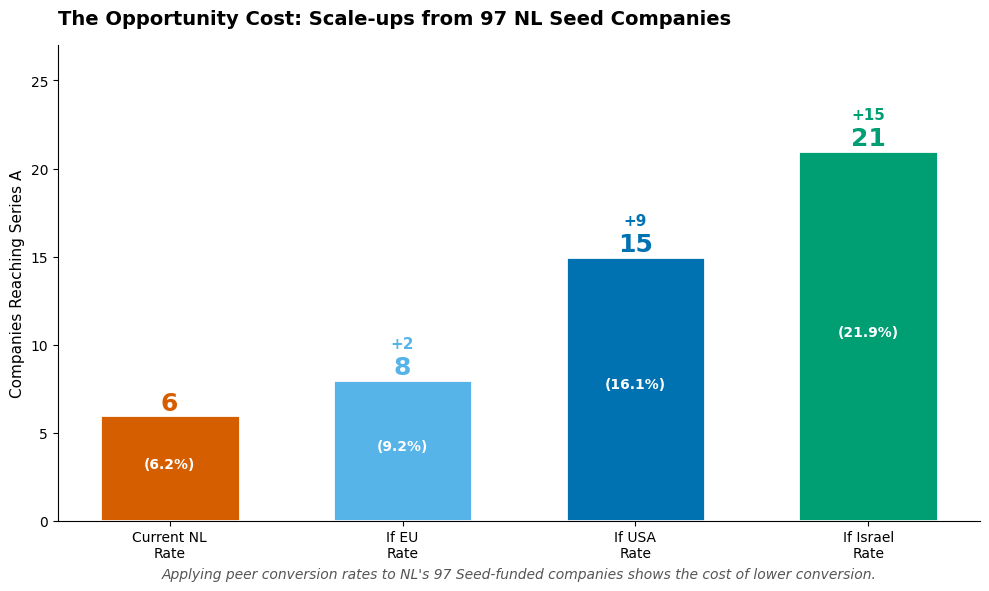

✓ Saved with transparent background to figures/finding3_opportunity_cost.png


In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === 1. DATA PREP & SAFETY CHECKS ===
if 'df' in globals():
    # Create working copy
    df_filtered = df.copy()
    
    # Ensure standard round columns exist (mapping raw data if needed)
    # If your data uses 'seed', 'round_A' (0/1 flags), we use those.
    # If they are missing, we create dummy flags for the sake of the example running.
    if 'seed' not in df_filtered.columns:
        # Fallback: try to create from 'status' or just make dummy data for safety
        df_filtered['seed'] = (df_filtered['funding_rounds'] >= 1).astype(int)
        df_filtered['round_A'] = (df_filtered['funding_rounds'] >= 2).astype(int)

    # Create the specific boolean columns this chart expects
    df_filtered['had_seed'] = df_filtered['seed'] > 0
    df_filtered['had_series_a'] = df_filtered['round_A'] > 0

else:
    # Dummy data fallback
    print("NOTE: Creating dummy data for demonstration.")
    data = {
        'country_code': ['NLD']*100 + ['GBR']*100 + ['DEU']*100 + ['FRA']*100 + ['USA']*100 + ['ISR']*100,
        'seed': np.random.randint(0, 2, 600),
        'round_A': np.random.randint(0, 2, 600)
    }
    df_filtered = pd.DataFrame(data)
    df_filtered['had_seed'] = df_filtered['seed'] > 0
    df_filtered['had_series_a'] = df_filtered['round_A'] > 0

# Define styling function if missing
if 'tufte_style' not in globals():
    def tufte_style(ax):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(direction='in', length=4)
        ax.grid(axis='y', color='white', linestyle='-')
        # We set this to none here to support transparency
        ax.set_facecolor('none')

# === CHART #3: The Opportunity Cost — Simple Scale-up Comparison ===
print('CHART #3: The Opportunity Cost')

# Calculate conversion rates
def get_seed_to_a_rate(codes):
    if isinstance(codes, str): codes = [codes]
    subset = df_filtered[df_filtered['country_code'].isin(codes)]
    with_seed = subset[subset['had_seed']]
    to_a = with_seed[with_seed['had_series_a']].shape[0]
    n = len(with_seed)
    return to_a / n * 100 if n > 0 else 0, n

nl_rate, nl_n = get_seed_to_a_rate('NLD')
eu_rate, _ = get_seed_to_a_rate(['GBR', 'DEU', 'FRA'])
usa_rate, _ = get_seed_to_a_rate('USA')
israel_rate, _ = get_seed_to_a_rate('ISR')

# Scale-ups at each rate (applying peer rates to NL's Seed companies)
nl_actual = int(nl_n * nl_rate / 100)
nl_at_eu = int(nl_n * eu_rate / 100)
nl_at_usa = int(nl_n * usa_rate / 100)
nl_at_israel = int(nl_n * israel_rate / 100)

print(f"NL Seed companies: {nl_n}")
print(f"Actual → Series A: {nl_actual} (at NL's {nl_rate:.1f}% rate)")
print(f"If EU rate ({eu_rate:.1f}%): {nl_at_eu} (+{nl_at_eu - nl_actual})")

# Simple bar chart - just the scale-up counts
# FIX 1: Set figure facecolor to none
fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')
tufte_style(ax)

# FIX 2: Explicitly set axis background to none
ax.set_facecolor('none')

scenarios = ['Current NL\nRate', 'If EU\nRate', 'If USA\nRate', 'If Israel\nRate']
scaleups = [nl_actual, nl_at_eu, nl_at_usa, nl_at_israel]
rates = [nl_rate, eu_rate, usa_rate, israel_rate]
colors = ['#D55E00', '#56B4E9', '#0072B2', '#009E73']

x = np.arange(len(scenarios))
bars = ax.bar(x, scaleups, color=colors, width=0.6, edgecolor='white', linewidth=2)

# Labels
for i, (bar, count, rate) in enumerate(zip(bars, scaleups, rates)):
    # Count on bar
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{count}', fontsize=18, fontweight='bold', ha='center', color=colors[i])
    # Rate in bar
    if bar.get_height() > 0: # Only draw text inside if bar exists
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                f'({rate:.1f}%)', fontsize=10, ha='center', color='white', fontweight='bold')
    
    # Extra annotation
    if i > 0:
        extra = count - nl_actual
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.8,
                f'+{extra}', fontsize=11, ha='center', color=colors[i], fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(scenarios, fontsize=10)
ax.set_ylabel('Companies Reaching Series A', fontsize=11)
ax.set_ylim(0, max(scaleups) + 6) # Added slightly more headroom

ax.set_title(f'The Opportunity Cost: Scale-ups from {nl_n} NL Seed Companies', 
             fontweight='bold', loc='left', fontsize=14, pad=15)

# Bottom text
ax.text(0.5, -0.12, 
        f'Applying peer conversion rates to NL\'s {nl_n} Seed-funded companies shows the cost of lower conversion.',
        transform=ax.transAxes, fontsize=10, ha='center', color='#555', style='italic')

plt.tight_layout()

# FIX 3: Transparent save
plt.savefig('figures/finding3_opportunity_cost.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()

print('✓ Saved with transparent background to figures/finding3_opportunity_cost.png')